# Customer Segmentation Using RFM Analysis in Python

This dataset consists of orders made in different countries from December 2010 to December 2011. The company is a UK-based online retailer that mainly sells unique all-occasion gifts. Many of its customers are wholesalers. 

Not sure where to begin? Scroll to the bottom to find challenges!

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv("online_retail.csv")
df2 = pd.read_csv("online_retail.csv")


## Data Dictionary
| Variable    | Explanation                                                                                                                       |
|-------------|-----------------------------------------------------------------------------------------------------------------------------------|
| InvoiceNo   | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c' it indicates a cancellation. |
| StockCode   | A 5-digit integral number uniquely assigned to each distinct product.                                                             |
| Description | Product (item) name                                                                                                               |
| Quantity    | The quantities of each product (item) per transaction                                                                             |
| InvoiceDate | The day and time when each transaction was generated                                                                              |
| UnitPrice   | Product price per unit in sterling (pound)                                                                                        |
| CustomerID  | A 5-digit integral number uniquely assigned to each customer                                                                      |
| Country     | The name of the country where each customer resides                                                                               |

[Source](https://archive.ics.uci.edu/ml/datasets/online+retail#)  of dataset.

**Citation:** Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

## Exploring the Dataset

In [2]:
def summary(df):
    display(df.head())
    display(df.info())
    display(df.describe())
    
summary(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Update InvoiceDate object to date time format

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Now we want to clean up the dataset by dropping na rows, dropping duplicates, and filtering for quantities greater than 0 and where unit price is greater than 0.

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna()
df = df.drop_duplicates()

Since we don't want to count Quantity less than zero and UnitPrice greater than zero, we filter for only those values that we want.

In [6]:
df = df[(df.Quantity>0) & (df.UnitPrice> 0)]

Add a Sales column that multiplies the Quantity column by the UnitPrice column and check df.info() to make sure the changes have gone through.

In [7]:
df['Sales'] = df['Quantity']*df['UnitPrice']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   Sales        392692 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


# Create RFM table

We will create a rfm table to store a 2d array of customer segments based on their RFM scores. We will start by converting the InvoiceDate from an object datatype to a date time format

In [8]:
df['InvoiceDate'].max()

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Since this dataset is from 2010-2011 we will use a relavant "now" date to determine the recency of transactions. Using a lambda function to subtract max InvoiceDate from now date to find the difference between days. We will also use the length of InvoiceNo to determine the frequency of the customer's purchases. Finally, we will sum the UnitPrice to determine the Monetary value of the customer transactions over the period of time in the dataset.

In [9]:
now = dt.datetime(2011, 12, 31)

In [10]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda day: (now - day.max()).days,
                                   'InvoiceNo': lambda num: len(num),
                                   'UnitPrice': lambda price: price.sum()
                                   })

col_list = ['Recency', 'Frequency', 'Monetary_Value']
rfm.columns = col_list

Create individual rfm scores by doing quintile cuts among Recency, Frequency, and Monetary Value columns and concatenating those individual scores to form the three digit rfm score.

In [11]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels = [5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'], 5, labels = [1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary_Value'], 5, labels = [1,2,3,4,5])

rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

Create segmentation map identifying scores and appropriate segments using regex so we can properly assign the right segment to the customer according to the rfm score.

In [12]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [13]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary_Value,R,F,M,RFM Score,Segment
CustomerID,,,,,,,,
12346.0,346,1,1.04,1,1,1,111,Hibernating
12347.0,23,182,481.21,5,5,5,555,Champions
12348.0,96,31,178.71,2,3,4,234,At Risk
12349.0,39,73,605.10,4,4,5,445,Loyal Customers
12350.0,331,17,65.30,1,2,2,122,Hibernating


Calculate the mean of each customer segment along each Recency, Frequency, and Monetary Value column to get an overview of the scores corresponding to each segment.

In [14]:
rfm.groupby('Segment').mean().sort_values('Monetary_Value')

,Recency,Frequency,Monetary_Value
Segment,,,
New Customers,27.421053,7.578947,28.693158
Promising,43.437500,7.758929,30.057232
Hibernating,230.711111,13.644444,55.828335
About to Sleep,73.176471,15.962848,62.839443
Potential Loyalists,36.629555,34.740891,113.011743
Need Attention,73.044118,41.274510,124.440000
At Risk,184.743816,56.779152,178.332562
Loyal Customers,54.198286,154.979192,493.720490
Can't Lose,165.851852,179.592593,576.423963


We will find out the value counts for each segment and use the rfm_segments index to create a treemap using Squarify.

In [15]:
rfm_segments = rfm['Segment'].value_counts()
rfm_segments.index

Index(['Hibernating', 'Loyal Customers', 'Champions', 'At Risk',
       'Potential Loyalists', 'About to Sleep', 'Need Attention', 'Promising',
       'Can't Lose', 'New Customers'],
      dtype='object')

# Plot RFM Segments into a Treemap using Squarify

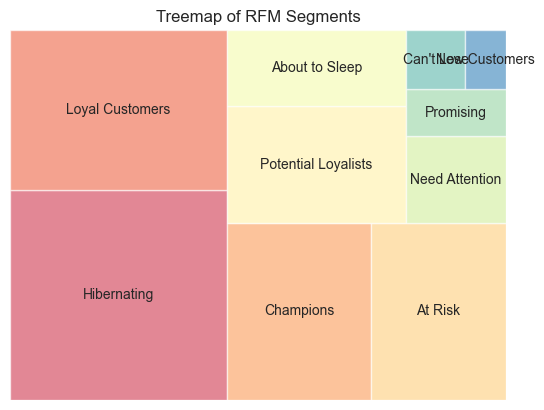

In [17]:
import squarify
sns.set_style(style="whitegrid") # set seaborn plot style
sizes= rfm['Segment'].value_counts() # proportions of the categories
label=rfm_segments.index
colors= sns.color_palette("Spectral", len(label))
squarify.plot(sizes=sizes, 
              label=label, 
              alpha=0.6,
              color=colors
             ).set(title='Treemap of RFM Segments')
plt.axis('off')
plt.show()


# Recommendations

Here we have a few recommendations that we could implement for each customer segment. This will help to make better targeted marketing messaging for our customer segments based on where they are in their customer journey. This might include sending out emails or creating remarketing campaigns to get certain customers to re-engage with us.

In [19]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.prospectsoft.com/prs-main/sitenews/blogimages/rfm-actions-grid.png?nocache=162627&action=download")